In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pyproj import CRS
from scipy.spatial import cKDTree

# Local application/library specific imports
import importlib
import project_functions as pf

# Reloading the local module 
importlib.reload(pf)

# Base path
base_path = 'C:/Users/Henri/Emilie/Thesis'

### Load data

In [3]:
# Load 2023 SVK data
SVK_path22 = base_path + '/data/2022_rain_observations.csv'
df22 = pd.read_csv(SVK_path22)
df22['time'] = pd.to_datetime(df22['time'])
df22= df22[df22['time'].dt.year == 2022] # Only keep 2022 data

# Load 2023 SVK data
SVK_path23 = base_path + '/data/2023_rain_observations.csv'
df23 = pd.read_csv(SVK_path23)
df23['time'] = pd.to_datetime(df23['time'])
df23= df23[df23['time'].dt.year == 2023] # Only keep 2023 data

# Concatenate the two dataframes
df = pd.concat([df22, df23], ignore_index=True)
df = df.set_index(df.columns[0])

In [4]:
# Load radar meta data
radar_path = base_path + '/data/meta_data/radar_meta_data.csv' 
radar_df = pd.read_csv(radar_path)

# Load gague station meta data
station_path = base_path + '/data/meta_data/SVK_stationsliste.txt' 
station_df = pd.read_csv(station_path,  sep=' ', index_col=False)
station_df.rename(columns={'05Nr': 'stationId'}, inplace=True)
station_df = station_df[station_df['Slutdato'].isna()] # Only keep active stations
station_df = station_df[['stationId', 'Stationsnavn', 'Northings', 'Eastings' ]] # Only keep relevant columns

In [5]:
station_df.head()

,stationId,Stationsnavn,Northings,Eastings
2,5025,FREDERIKSHAVN_MATERIELGÅRD,6368352,589564
3,5027,FREDERIKSHAVN_CENTRALRENSEANLÆG,6365840,591625
5,5045,VODSKOV,6328973,562047
7,5047,SULSTED_STOKBROVEJ_PUMPEST.,6336906,557766
8,5049,GISTRUP,6317424,560707


In [4]:
# Correct mistake in SVK data
station_df['Northings'] = station_df['Northings'].apply(lambda x: x / 1e8 if x > 1e9 else x)
station_df['Eastings'] = station_df['Eastings'].apply(lambda x: x / 1e9 if x > 1e9 else x)

# Apply transformation (from northings/eastings to lat/lon)
station_df['Longitude'], station_df['Latitude'] = zip(*station_df.apply(lambda row: pf.transform_coordinates_from_EUREF89_to_WGS84(row['Eastings'], row['Northings']), axis=1))

# Filter such that only stations with measured data are included
station_df['stationId_str'] = station_df['stationId'].astype(str)
station_df = station_df[station_df['stationId_str'].isin(df.columns)]

In [5]:
# Mark gauges than is located in the cone of silence (25 km from radar)
vec_haversine = np.vectorize(pf.haversine) # Vectorize the haversine function 
station_df['Within_25km_of_Radar'] = False # Initialize a column with False indicating no radar within 25 km

for index, station in station_df.iterrows():
    # Calculate distances to all radars
    distances = vec_haversine(station['Longitude'], station['Latitude'],
                              radar_df['Longitude'].values, radar_df['Latitude'].values)
    
    # Check if any distance is less than 25 km
    if np.any(distances < 25):
        # Update the column for this station
        station_df.at[index, 'Within_25km_of_Radar'] = True

In [6]:
# Get radar coordinate grid with longitudes and latitudes
x_radar_coords = np.arange(-421364.8 - 500, 569635.2 + 500, 500) 
y_radar_coords = np.arange(468631 + 500, -394369 - 500, -500)
dmi_stere_crs = CRS("+proj=stere +ellps=WGS84 +lat_0=56 +lon_0=10.5666 +lat_ts=56") # raw data CRS projection
plotting_crs = 'epsg:4326' # the CRS projection you want to plot the data in
radar_lons, radar_lats = pf.transform_raster_grid_coordinates(x_radar_coords, y_radar_coords, dmi_stere_crs, plotting_crs) 

In [7]:
# Calculate midpoints for longitude and latitude separately
mid_lons = pf.calculate_midpoints(radar_lons)
mid_lats = pf. calculate_midpoints(radar_lats)

# Prepare the radar points (midpoints of pixels) for KDTree
radar_midpoints = np.column_stack((mid_lons.flatten(), mid_lats.flatten()))

# Build a KDTree for fast nearest-neighbor lookup using radar midpoints
tree = cKDTree(radar_midpoints)

# Convert station locations to an array of (longitude, latitude) pairs for searching
station_points = station_df[['Longitude', 'Latitude']].values

# Find the nearest radar pixel midpoint for each station
distances, indices_1d = tree.query(station_points)

# Translate the 1D indices back to 2D indices in the radar arrays
# Note: We subtract 1 from the shape of the radar arrays because the midpoints grid is smaller
num_cols = radar_lons.shape[1] - 1
indices_row = indices_1d // num_cols
indices_col = indices_1d % num_cols

# Add the indices to station_df
station_df['radar_pixel_row'] = indices_row
station_df['radar_pixel_col'] = indices_col

### Train/test split

In [8]:
importlib.reload(pf)
# Split data into test and train set using K-means clustering for geographical spread of test stations
df_clean = station_df[station_df['Within_25km_of_Radar'] == False] # Remove stations within 25 km of radar
train_station_ids, val_station_ids, test_station_ids = pf.split_train_val_test_using_Kmeans(df_clean, n_clusters = 10)

print("Total number of stations:", len(station_df))
print('Number of excluded stations in cone of silence:', len(station_df[station_df['Within_25km_of_Radar'] == True]))
print('Number of train guages:', len(train_station_ids))
print('Number of validation guages:', len(val_station_ids))
print('Number of test guages:', len(test_station_ids))

print('Train stations:', train_station_ids)
print('Validation stations:', val_station_ids)
print('Test stations:', test_station_ids)

Total number of stations: 191
Number of excluded stations in cone of silence: 19
Number of train guages: 140
Number of validation guages: 16
Number of test guages: 16
Train stations: [5045, 5047, 5052, 5054, 5056, 5058, 5061, 5115, 5117, 5279, 5291, 5121, 5122, 5123, 5124, 5125, 5130, 5190, 5192, 5207, 5273, 5281, 5282, 5283, 5180, 5230, 5232, 5235, 5237, 5239, 5240, 5245, 5247, 5248, 5251, 5252, 5257, 5260, 5265, 5370, 5390, 5397, 5363, 5377, 5403, 5404, 5407, 5409, 5411, 5412, 5414, 5415, 5417, 5418, 5419, 5422, 5427, 5429, 5445, 5465, 5479, 5485, 5490, 5509, 5521, 5540, 5901, 5905, 5915, 5920, 5925, 5930, 5555, 5573, 5574, 5576, 5577, 5580, 5581, 5585, 5590, 5593, 5596, 5600, 5607, 5618, 5810, 5815, 5824, 5825, 5830, 5840, 5849, 5855, 5859, 5865, 5870, 5565, 5570, 5602, 5610, 5620, 5622, 5623, 5625, 5628, 5633, 5641, 5642, 5645, 5647, 5655, 5660, 5665, 5670, 5675, 5680, 5685, 5697, 5698, 5705, 5710, 5713, 5725, 5730, 5731, 5733, 5740, 5745, 5759, 5763, 5765, 5771, 5775, 5781, 5790, 

C:\Users\Henri\anaconda3\envs\pytorch_trial_0\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


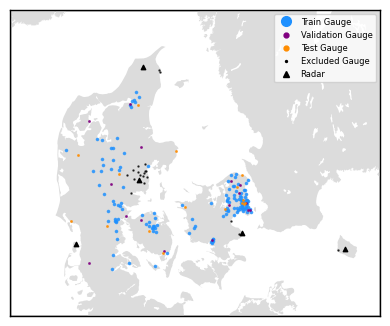

In [9]:
# Plot train/test/excluded gagues
save_path = base_path + '/figures/Train_Test_Station_Map.png'
importlib.reload(pf)
pf.plot_test_train_val_split(station_df, radar_df, test_station_ids, val_station_ids, save_path=save_path)

# Generate data for model type 3

In [10]:
import os
from PIL import Image
import csv
import gc

def save_image(image_array, file_dir, file_name):
    try:
        # Ensure the directory exists
        os.makedirs(file_dir, exist_ok=True)
        file_path = os.path.join(file_dir, file_name)
        # Convert the array to an image and save it
        image = Image.fromarray(image_array.astype('uint8'))
        image.save(file_path)
        image.close()  # Make sure to close the image to free up system resources
        return file_path
    except Exception as e:
        print(f"Failed to save image {file_name} at {file_dir}: {e}")
        return None

def toy(date_input):
    days_in_year = 365.25  # Average to account for leap years
    date = pd.to_datetime(date_input)
    day_of_year = date.day_of_year
    sin_time_of_year = np.sin(2 * np.pi * day_of_year / days_in_year)
    cos_time_of_year = np.cos(2 * np.pi * day_of_year / days_in_year)
    return sin_time_of_year, cos_time_of_year

def tod(time_input):
    time = pd.to_datetime(time_input)
    seconds_since_midnight = (time - time.normalize()).seconds
    seconds_in_a_day = 24 * 60 * 60
    fraction_of_day = seconds_since_midnight / seconds_in_a_day
    sin_time_of_day = np.sin(2 * np.pi * fraction_of_day)
    cos_time_of_day = np.cos(2 * np.pi * fraction_of_day)
    return sin_time_of_day, cos_time_of_day

def generate_ZR_data_with_features_and_images(station_ids, df, station_df, data_dir, start_date, end_date, dist_coast, dist_radar, topo, dat, crop_size):
    # Convert start and end dates to Timestamps and filter dates
    start_date_dt, end_date_dt = pd.to_datetime(start_date), pd.to_datetime(end_date)
    filtered_dates = df.index[(df.index >= start_date_dt) & (df.index <= end_date_dt)]
    
    # CSV file path and initial setup
    csv_file_path = f"{base_path}/data/{dat}ZR_v3_{crop_size}.csv"
    fieldnames = ['timestamp', 'stationId', 'R', 'Z', 'dBZ', 'radar_norm', 'dist_coast', 'dist_radar', 'topo', 'toy_sin', 'toy_cos', 'tod_sin', 'tod_cos', 'cropped_radar_image_path', 'r_idx', 'c_idx']
    with open(csv_file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
    
    # Loop through all timestamps and load radar images
    for date in tqdm(filtered_dates):
        year, month, day, hour, minute = date.year, date.month, date.day, date.hour, date.minute
        file_path = f"{data_dir}/{year}/{year}/{month:02d}/{day:02d}/dk.com.{year}{month:02d}{day:02d}{hour:02d}{minute:02d}.500_max.h5"
        radar_image, success = pf.load_radar_image(file_path)
        if not success:
            continue
        
        # For all radar images, go through each station and make a row in the data frame and save image
        for station_ID in station_ids:
            try:
                process_data_for_station(date, station_ID, df, station_df, data_dir, writer, fieldnames, crop_size, dist_coast, dist_radar, topo, dat, radar_image, year, month, day, hour, minute, csv_file_path)
            except Exception as e:
                print(f"Error processing {date} for station {station_ID}: {e}")
        
        gc.collect()  # Call garbage collector to prevent memory failure
        del radar_image # Ensure the radar image is deleted after processing

def process_data_for_station(date, station_ID, df, station_df, data_dir, writer, fieldnames, crop_size, dist_coast, dist_radar, topo, dat, radar_image, year, month, day, hour, minute, csv_file_path):
    # Pixel indices in radar image for gauge
    r_idx, c_idx = station_df.loc[station_df['stationId'] == station_ID, ['radar_pixel_row', 'radar_pixel_col']].iloc[0]
    
    # R, Z and dBZ data
    rain_gauge_value = df.loc[date, str(station_ID)]
    dBZ = pf.raw_radar_data_to_dbz(radar_image[r_idx, c_idx])
    Z = pf.dbz_to_Z(dBZ)
    
    # Crop and save image
    _, _, _, _, cropped_radar_image = pf.crop_image(radar_image, r_idx, c_idx, crop_size=crop_size)
    formatted_date = date.strftime("%Y-%m-%d_%H-%M-%S")
    image_dir = f"{base_path}/data/images/{dat}/{year}/{month:02d}/{day:02d}/{hour:02d}{minute:02d}"
    file_name = f"cropped_{formatted_date}_{station_ID}_{crop_size}.png"
    cropped_image_path = save_image(cropped_radar_image, image_dir, file_name)
    
    # Make row in data frame
    sample_dict = build_sample_dict(date, station_ID, rain_gauge_value, dBZ, Z, radar_image, r_idx, c_idx, dist_coast, dist_radar, topo, cropped_image_path)
    with open(csv_file_path, 'a', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writerow(sample_dict)

def build_sample_dict(date, station_ID, rain_gauge_value, dBZ, Z, radar_image, r_idx, c_idx, dist_coast, dist_radar, topo, cropped_image_path):
    sin_toy, cos_toy = toy(date)
    sin_tod, cos_tod = tod(date)
    return {
        'timestamp': date, 'stationId': station_ID, 'R': rain_gauge_value, 'Z': Z[0], 'dBZ': dBZ[0],
        'radar_norm': radar_image[r_idx, c_idx]/255.0, 'dist_coast': dist_coast[r_idx, c_idx],
        'dist_radar': dist_radar[r_idx, c_idx], 'topo': topo[r_idx, c_idx], 'toy_sin': sin_toy,
        'toy_cos': cos_toy, 'tod_sin': sin_tod, 'tod_cos': cos_tod,
        'cropped_radar_image_path': cropped_image_path, 'r_idx': r_idx, 'c_idx': c_idx
    }

In [11]:
# Load features
dist_coast = np.load('climate.npy')
dist_radar = np.load('dist_radar_01.npy')
topo = np.load('topo_01.npy') 

# Normalize with Min-Max Scaling to [0, 1]
def min_max_normalize(arr):
    return (arr - arr.min()) / (arr.max() - arr.min())

dist_coast = min_max_normalize(dist_coast)
dist_radar = min_max_normalize(dist_radar)
topo= min_max_normalize(topo)

# Initialize
data_dir =  base_path + '/data/radar'
CROP_SIZE = 63

#### Train data

In [12]:
generate_ZR_data_with_features_and_images(train_station_ids, df, station_df, data_dir,
                                          start_date='20220402', end_date='20230401', 
                                          dist_coast=dist_coast, dist_radar=dist_radar, topo=topo, 
                                          dat='train', crop_size=CROP_SIZE)

100%|██████████| 104833/104833 [7:31:09<00:00,  3.87it/s] 


#### Validation data

In [13]:
generate_ZR_data_with_features_and_images(val_station_ids, df, station_df, data_dir, 
                                                           start_date='20230402', end_date='20231231', 
                                                           dist_coast=dist_coast, dist_radar=dist_radar, topo=topo, 
                                                           dat = 'val', crop_size = CROP_SIZE)

100%|██████████| 78625/78625 [2:09:04<00:00, 10.15it/s]  


#### Test data

In [14]:
generate_ZR_data_with_features_and_images(test_station_ids, df, station_df, data_dir, 
                                                            start_date='20230402', end_date='20231231', 
                                                            dist_coast=dist_coast, dist_radar=dist_radar, topo=topo, 
                                                            dat='test', crop_size = CROP_SIZE)

100%|██████████| 78625/78625 [2:03:47<00:00, 10.59it/s]  
